# Exploring Jane Addams Letters 1901-1927

### MATH-390 | 01 | ADV TOPICS: NETWORK SCIENCE | Professor Beecher

### Tina Nosrati
### last update: 12/01/2024


In [1]:
#packages
import pandas as pd
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
import community as community_louvain


# Data Preprocessing

In [2]:
#loading text processing essentials
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Tina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#defining text procesign functions
def remove_signs(text):
    return re.sub(r'[^A-Za-z0-9\s]', '', text)

def lowercase_text(text):
    return text.lower()

def remove_stopwords(text):
    tokens = word_tokenize(text)
    return ' '.join([word for word in tokens if word not in stop_words])

def apply_stemming(text):
    tokens = word_tokenize(text)
    return ' '.join([stemmer.stem(word) for word in tokens])

def apply_lemmatization(text):
    tokens = word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(word) for word in tokens])

def preprocess_text(text):
    text = remove_signs(text)
    text = lowercase_text(text)
    text = remove_stopwords(text)
    text = apply_stemming(text)
    text = apply_lemmatization(text)
    return text

In [5]:
def clean_dataset_by_tag_frequency(df, tag_column='tags', min_frequency=10):
    df = df.dropna(subset=[tag_column])

    tag_counts = df[tag_column].value_counts()
    
    valid_tags = tag_counts[tag_counts >= min_frequency].index
    
    cleaned_df = df[df[tag_column].isin(valid_tags)]
    
    return cleaned_df


In [9]:
#reading the data and keeping the necessary columns
df=pd.read_csv("dataset.csv")
df.head()
df_text=df[['Identifier','Title','Subject','Date','Text', 'locations', 'tags']]
df_text=df_text.dropna()
#apply test preprocesing
df_text['Text'] = df_text['Text'].apply(preprocess_text)
df_text = clean_dataset_by_tag_frequency(df_text, tag_column='tags', min_frequency=10)

In [11]:
#saving cleaned data
df_text.to_csv("cleaned_data.csv")

# Dividing datasets

In [12]:
df_text['Date'] = pd.to_datetime(df_text['Date'], errors='coerce', utc=True)

df_text = df_text.dropna(subset=['Date'])

df_text['Date'] = df_text['Date'].dt.tz_convert(None)

df_1901_1909 = df_text[(df_text['Date'].dt.year >= 1901) & (df_text['Date'].dt.year <= 1909)]
df_1910_1919 = df_text[(df_text['Date'].dt.year >= 1910) & (df_text['Date'].dt.year <= 1919)]
df_1920_1927 = df_text[(df_text['Date'].dt.year >= 1920) & (df_text['Date'].dt.year <= 1927)]

In [13]:
df_1901_1909.to_csv('df_1901_1909.csv')
df_1910_1919.to_csv('df_1910_1919.csv')
df_1920_1927.to_csv('df_1920_1927.csv')

# Network Analysis Functions

### Vectorization and cosine similarity

In [17]:
#TFIDF vectorization and cosine similarity
def TFIDF(df):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['Text'])
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    cosine_sim_df = pd.DataFrame(cosine_sim, index=df.index, columns=df.index)
    #cosine_sim_df.head()
    return cosine_sim_df


### Similarity stat

In [18]:
#similarity stats
def sim_stat(similarity_matrix):
    similarity_matrix = np.array(similarity_matrix)
    np.fill_diagonal(similarity_matrix, np.nan)
    
    min_val = np.nanmin(similarity_matrix)
    max_val = np.nanmax(similarity_matrix)
    mean_val = np.nanmean(similarity_matrix)
    std_dev = np.nanstd(similarity_matrix)
    
    print(f"Minimum similarity (excluding diagonal): {min_val:.4f}")
    print(f"Maximum similarity (excluding diagonal): {max_val:.4f}")
    print(f"Mean similarity (excluding diagonal): {mean_val:.4f}")
    print(f"Standard Deviation of similarity (excluding diagonal): {std_dev:.4f}")
    
    return mean_val, std_dev

### Finding the threshold


#### T= mean similarity + k * standard deviation similarity

In [19]:
#estimate the best k value
def find_k(cossimilarity_matrix,mean_val, std_dev):
    upper_tri_matrix = np.triu(cossimilarity_matrix, k=1)
    similarity_scores = upper_tri_matrix[upper_tri_matrix != 0]
    k_values = np.linspace(0, 10, 20) 
    retained_ratios = []

    for k in k_values:
        threshold = mean_val + k * std_dev
        retained = similarity_scores[similarity_scores > threshold]
        retained_ratio = len(retained) / len(similarity_scores)
        retained_ratios.append(retained_ratio)

    plt.figure(figsize=(8, 5))
    plt.plot(k_values, retained_ratios, marker='o')
    plt.title("Retained Similarities vs k")
    plt.xlabel("k Value")
    plt.ylabel("Retained Ratio")
    plt.grid()
    plt.show()

### Plot the network

In [21]:
#plot
def plot_network(similarity_df):
    G = nx.from_pandas_edgelist(similarity_df, source='Letter_A', target='Letter_B', edge_attr='Similarity')
    pos = nx.spring_layout(G, seed=42, k=0.8) 
    weights = [d['Similarity'] for _, _, d in G.edges(data=True)]
    norm = plt.Normalize(vmin=min(weights), vmax=max(weights))
    colors = plt.cm.viridis(norm(weights))

    plt.figure(figsize=(20, 15))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color=colors, width=2, node_size=200, font_size=3, font_weight='bold')
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Similarity', fontsize=12)

    plt.title("Graph Visualization of the Similarity Network")
    plt.show()

In [22]:
#Network Metrics
def analyze_graph(df):
    G = nx.from_pandas_edgelist(df, 'Letter_A', 'Letter_B', edge_attr='Similarity', create_using=nx.Graph())

    nodes = len(G.nodes)
    links = len(G.edges)
    print("Size of the network: ", nodes)
    print("Number of links in the network: ", links)

    density = nx.density(G)
    print(f"Network Density: {density}")

    clustering_coeff = nx.average_clustering(G, weight='Similarity')
    print(f"Average Clustering Coefficient: {clustering_coeff}")

    num_components = nx.number_connected_components(G)
    print(f"Number of Connected Components: {num_components}")

    if nx.is_connected(G):
        avg_path_length = nx.average_shortest_path_length(G, weight='Similarity')
        print(f'Average Path Length: {avg_path_length}')
    else:
        print("Graph is not connected, cannot compute average path length.")

    path_lengths = dict(nx.all_pairs_dijkstra_path_length(G, weight='Similarity'))
    all_lengths = []
    for source, target_lengths in path_lengths.items():
        all_lengths.extend(target_lengths.values())
    plt.hist(all_lengths, bins=20, edgecolor='black')
    plt.title('Distribution of Path Lengths')
    plt.xlabel('Path Length')
    plt.ylabel('Frequency')
    plt.show()

    if nx.is_connected(G):
        diameter = nx.diameter(G)
        print(f'Diameter: {diameter}')
    else:
        print("Graph is not connected, cannot compute diameter.")

    degrees = [val for (node, val) in G.degree()]
    avg_degree = np.mean(degrees)
    print(f'Average Degree: {avg_degree}')

    plt.hist(degrees, bins=20, edgecolor='black')
    plt.title('Distribution of Degree')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.show()

    print(f'Degree Distribution Stats:\n Mean: {np.mean(degrees)}, Std: {np.std(degrees)}, Median: {np.median(degrees)}')

    weights = [d['Similarity'] for u, v, d in G.edges(data=True)]
    plt.hist(weights, bins=20, edgecolor='black')
    plt.title('Distribution of Weights')
    plt.xlabel('Weight')
    plt.ylabel('Frequency')
    plt.show()

    print(f'Weight Distribution Stats:\n Mean: {np.mean(weights)}, Std: {np.std(weights)}, Median: {np.median(weights)}')



In [23]:
# More metrics
def advanced_metrics(df):
    G = nx.from_pandas_edgelist(df, 'Letter_A', 'Letter_B', edge_attr='Similarity', create_using=nx.Graph())

    degree_centrality = nx.degree_centrality(G)
    top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    print("Top 10 Degree Centrality:")
    print(top_degree_centrality)

    betweenness_centrality = nx.betweenness_centrality(G, weight='Similarity')
    top_betweenness_centrality = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    print("Top 10 Betweenness Centrality:")
    print(top_betweenness_centrality)

    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, weight='Similarity')
    top_eigenvector_centrality = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
    print("Top 10 Eigenvector Centrality:")
    print(top_eigenvector_centrality)

    hubs, authorities = nx.hits(G, max_iter=1000, normalized=True)
    top_hubs = sorted(hubs.items(), key=lambda x: x[1], reverse=True)[:10]
    top_authorities = sorted(authorities.items(), key=lambda x: x[1], reverse=True)[:10]
    print("Top 10 Hubs:")
    print(top_hubs)
    print("Top 10 Authorities:")
    print(top_authorities)

    strength = dict(G.degree(weight='Similarity'))
    top_strength = sorted(strength.items(), key=lambda x: x[1], reverse=True)[:10]
    print("Top 10 Strength (Weighted Degree):")
    print(top_strength)

    # Calculate and print modularity
    #partition = community_louvain.best_partition(G, weight='Similarity')
    #modularity = community_louvain.modularity(partition, G)
    #print(f"Network Modularity: {modularity}")
    


# Network Analysis Complete 

Minimum similarity (excluding diagonal): 0.0000
Maximum similarity (excluding diagonal): 0.9623
Mean similarity (excluding diagonal): 0.0507
Standard Deviation of similarity (excluding diagonal): 0.0368


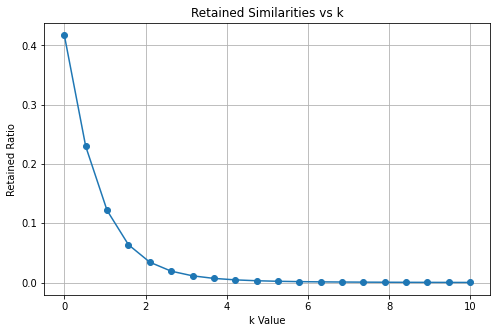

Similarity Threshold: 0.23454209901284923
      Letter_A  Letter_B  Similarity
1003      1135      1151    0.962264
490        399       860    0.940704
808        859       861    0.926956
1009      1151      1212    0.880977
793        857       859    0.876256
...        ...       ...         ...
2185      3478      3514    0.234647
2020      2881      2964    0.234640
1775      2238      2500    0.234638
2174      3440      3443    0.234634
1114      1309      2602    0.234545

[2240 rows x 3 columns]


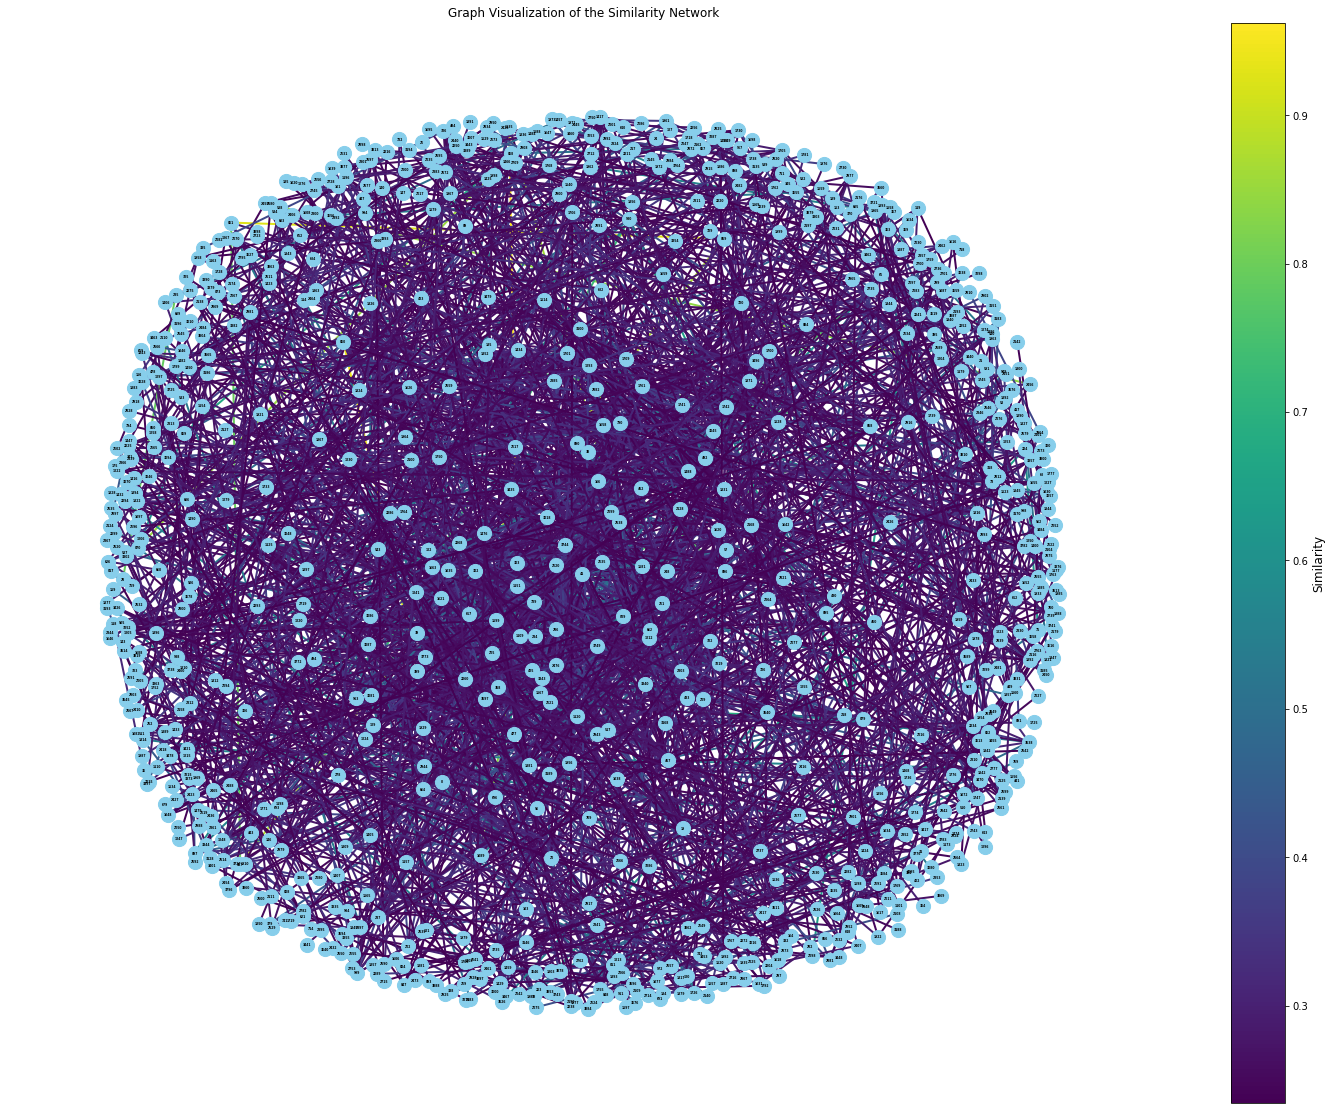

In [24]:
#full dataset
cosine_sim_df=TFIDF(df_text)
mean, std = sim_stat(cosine_sim_df)
find_k(cosine_sim_df,mean,std)
k=5
similarity_threshold = mean + k * std
print("Similarity Threshold:", similarity_threshold)
cosine_sim_df = pd.DataFrame(cosine_sim_df)
mask = (cosine_sim_df > similarity_threshold) & np.triu(np.ones(cosine_sim_df.shape), k=1).astype(bool)
similarity_df = cosine_sim_df.where(mask).stack().reset_index()
similarity_df.columns = ['Row1', 'Row2', 'Similarity']
similarity_df = similarity_df.sort_values(by='Similarity', ascending=False)
similarity_df.rename(columns={similarity_df.columns[0]: 'Letter_A', similarity_df.columns[1]: 'Letter_B'}, inplace=True)
print(similarity_df)
plot_network(similarity_df)
similarity_df.to_csv("similarity_df_complete.csv")




__________________________________Complete Network Metrics__________________________________
Size of the network:  861
Number of links in the network:  2240
Network Density: 0.0060502930610701455
Average Clustering Coefficient: 0.10753217531696688
Number of Connected Components: 62
Graph is not connected, cannot compute average path length.


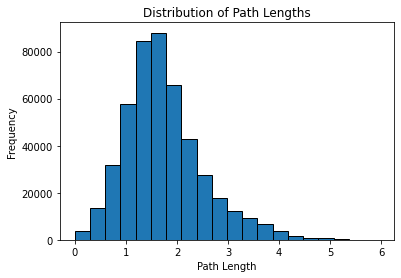

Graph is not connected, cannot compute diameter.
Average Degree: 5.203252032520325


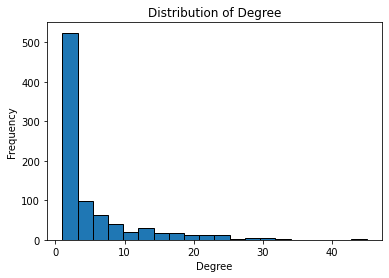

Degree Distribution Stats:
 Mean: 5.203252032520325, Std: 6.204362379563607, Median: 3.0


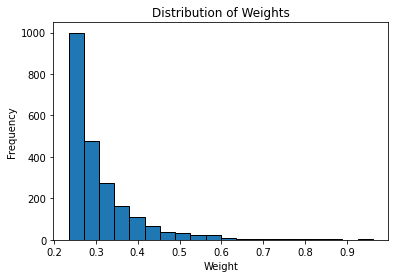

Weight Distribution Stats:
 Mean: 0.30944754840149014, Std: 0.09113976028802985, Median: 0.27827075496079134
Top 10 Degree Centrality:
[(1658, 0.05232558139534883), (248, 0.037209302325581395), (39, 0.03604651162790698), (261, 0.03488372093023256), (166, 0.03488372093023256), (234, 0.03488372093023256), (41, 0.03488372093023256), (789, 0.033720930232558136), (1742, 0.033720930232558136), (1035, 0.033720930232558136)]
Top 10 Betweenness Centrality:
[(1035, 0.11523675447383382), (1709, 0.09444188753824079), (1125, 0.08721065598180686), (938, 0.07984405880282643), (3813, 0.06523269350515742), (3463, 0.06518666919349161), (1701, 0.06252267374177653), (3100, 0.05886509462057016), (2250, 0.053139128786853285), (2197, 0.05134688794433765)]
Top 10 Eigenvector Centrality:
[(261, 0.289361720205199), (234, 0.2732611523539699), (166, 0.26392913480667635), (248, 0.25187814554285953), (41, 0.24985253855901476), (209, 0.24270325431561202), (57, 0.24149176046936882), (39, 0.24045780466644864), (286, 0

In [25]:
print("__________________________________Complete Network Metrics__________________________________")
analyze_graph(similarity_df)
advanced_metrics(similarity_df)

# Network Analysis 1901-1909 

Minimum similarity (excluding diagonal): 0.0000
Maximum similarity (excluding diagonal): 0.7404
Mean similarity (excluding diagonal): 0.0628
Standard Deviation of similarity (excluding diagonal): 0.0381


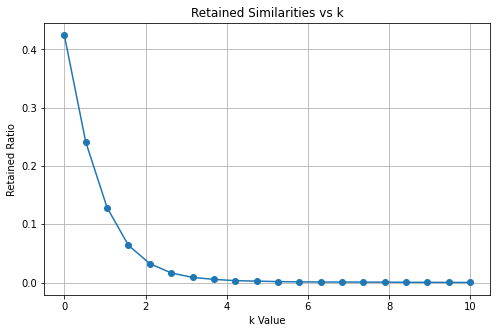

Similarity Threshold: 0.2534814594175787
    Letter_A  Letter_B  Similarity
50      3772      3773    0.740417
44      3655      3656    0.532264
34      3538      3540    0.483602
9       3343      3496    0.473999
11      3343      3772    0.473802
31      3526      3540    0.470839
12      3343      3773    0.458112
2       3183      3189    0.436279
28      3496      3772    0.422951
46      3676      3678    0.416045
29      3496      3773    0.413535
30      3526      3538    0.406522
49      3744      3749    0.404807
4       3185      3443    0.393989
39      3540      3749    0.381646
22      3393      3397    0.377056
3       3183      3470    0.376521
51      3800      3804    0.367844
54      3877      3878    0.365631
33      3526      3749    0.364789
10      3343      3597    0.357934
6       3193      3401    0.350169
47      3735      3744    0.333965
27      3496      3597    0.332894
48      3735      3749    0.313549
43      3597      3773    0.308708
5       3189  

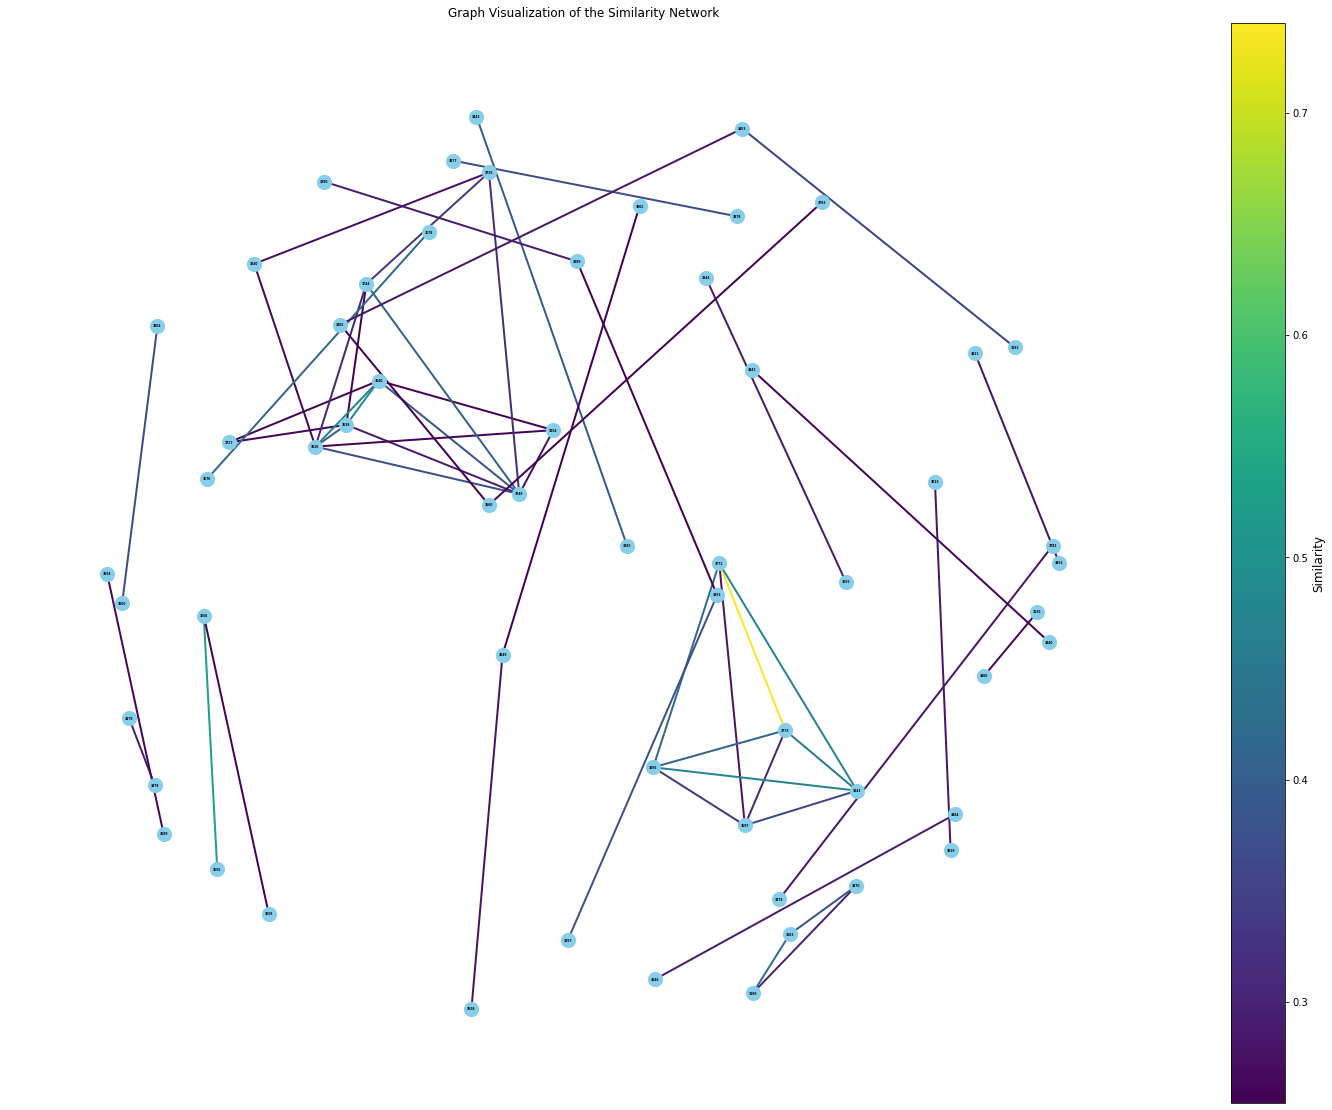

In [26]:
#1901-1909
cosine_sim_df_1901_1909=TFIDF(df_1901_1909)
mean_1901_1909, std_1901_1909 = sim_stat(cosine_sim_df_1901_1909)
find_k(cosine_sim_df_1901_1909,mean_1901_1909,std_1901_1909)
k=5
similarity_threshold_1901_1909 = mean_1901_1909 + k * std_1901_1909
print("Similarity Threshold:", similarity_threshold_1901_1909)
cosine_sim_df_1901_1909 = pd.DataFrame(cosine_sim_df_1901_1909)
mask = (cosine_sim_df_1901_1909 > similarity_threshold_1901_1909) & np.triu(np.ones(cosine_sim_df_1901_1909.shape), k=1).astype(bool)
similarity_df_1901_1909 = cosine_sim_df_1901_1909.where(mask).stack().reset_index()
similarity_df_1901_1909.columns = ['Row1', 'Row2', 'Similarity']
similarity_df_1901_1909 = similarity_df_1901_1909.sort_values(by='Similarity', ascending=False)
similarity_df_1901_1909.rename(columns={similarity_df_1901_1909.columns[0]: 'Letter_A', similarity_df_1901_1909.columns[1]: 'Letter_B'}, inplace=True)
print(similarity_df_1901_1909)
plot_network(similarity_df_1901_1909)
similarity_df_1901_1909.to_csv("similarity_df_1901_1909.csv")



__________________________________1901-1909 Network Metrics__________________________________
Size of the network:  58
Number of links in the network:  55
Network Density: 0.03327283726557774
Average Clustering Coefficient: 0.11482206882734021
Number of Connected Components: 20
Graph is not connected, cannot compute average path length.


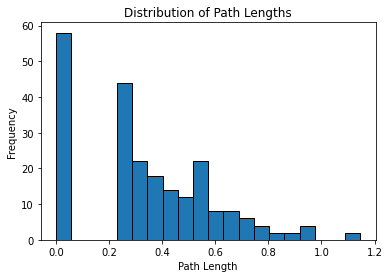

Graph is not connected, cannot compute diameter.
Average Degree: 1.896551724137931


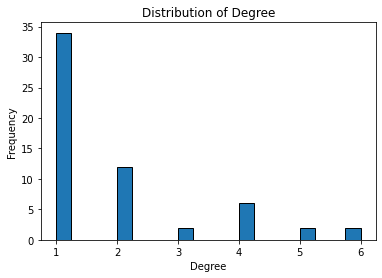

Degree Distribution Stats:
 Mean: 1.896551724137931, Std: 1.3732626035682676, Median: 1.0


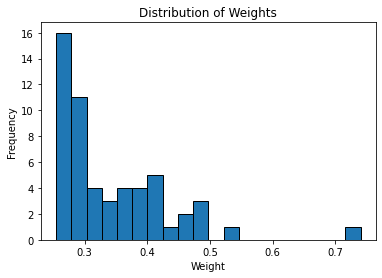

Weight Distribution Stats:
 Mean: 0.3401787098161276, Std: 0.09199464075950556, Median: 0.3072477699765658
Top 10 Degree Centrality:
[(3526, 0.10526315789473684), (3749, 0.10526315789473684), (3538, 0.08771929824561403), (3540, 0.08771929824561403), (3772, 0.07017543859649122), (3773, 0.07017543859649122), (3343, 0.07017543859649122), (3496, 0.07017543859649122), (3744, 0.07017543859649122), (3597, 0.07017543859649122)]
Top 10 Betweenness Centrality:
[(3538, 0.0037593984962406013), (3526, 0.0037593984962406013), (3365, 0.002506265664160401), (3749, 0.0018796992481203006), (3401, 0.0018796992481203006), (3560, 0.0018796992481203006), (3744, 0.0012531328320802004), (3393, 0.0012531328320802004), (3389, 0.0012531328320802004), (3656, 0.0006265664160401002)]
Top 10 Eigenvector Centrality:
[(3772, 0.49571770526780884), (3773, 0.49507322909680596), (3343, 0.4543688088244995), (3496, 0.4290625759842488), (3597, 0.3444134894798609), (3526, 0.00014260876323222944), (3749, 0.00013822036230503915

In [27]:
print("__________________________________1901-1909 Network Metrics__________________________________")
analyze_graph(similarity_df_1901_1909)
advanced_metrics(similarity_df_1901_1909)

# Network Analysis Complete 1910-1919

Minimum similarity (excluding diagonal): 0.0000
Maximum similarity (excluding diagonal): 0.8605
Mean similarity (excluding diagonal): 0.0550
Standard Deviation of similarity (excluding diagonal): 0.0391


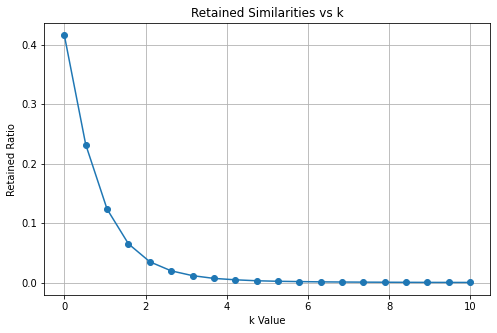

Similarity Threshold: 0.2534814594175787
     Letter_A  Letter_B  Similarity
565      2620      2635    0.860480
514      2455      2456    0.843284
571      2620      2735    0.748868
458      2097      2098    0.635068
572      2621      2635    0.622061
..        ...       ...         ...
269      1700      1755    0.250913
34       1248      1434    0.250714
265      1663      2128    0.250627
153      1466      1709    0.250617
22       1220      1241    0.250605

[706 rows x 3 columns]


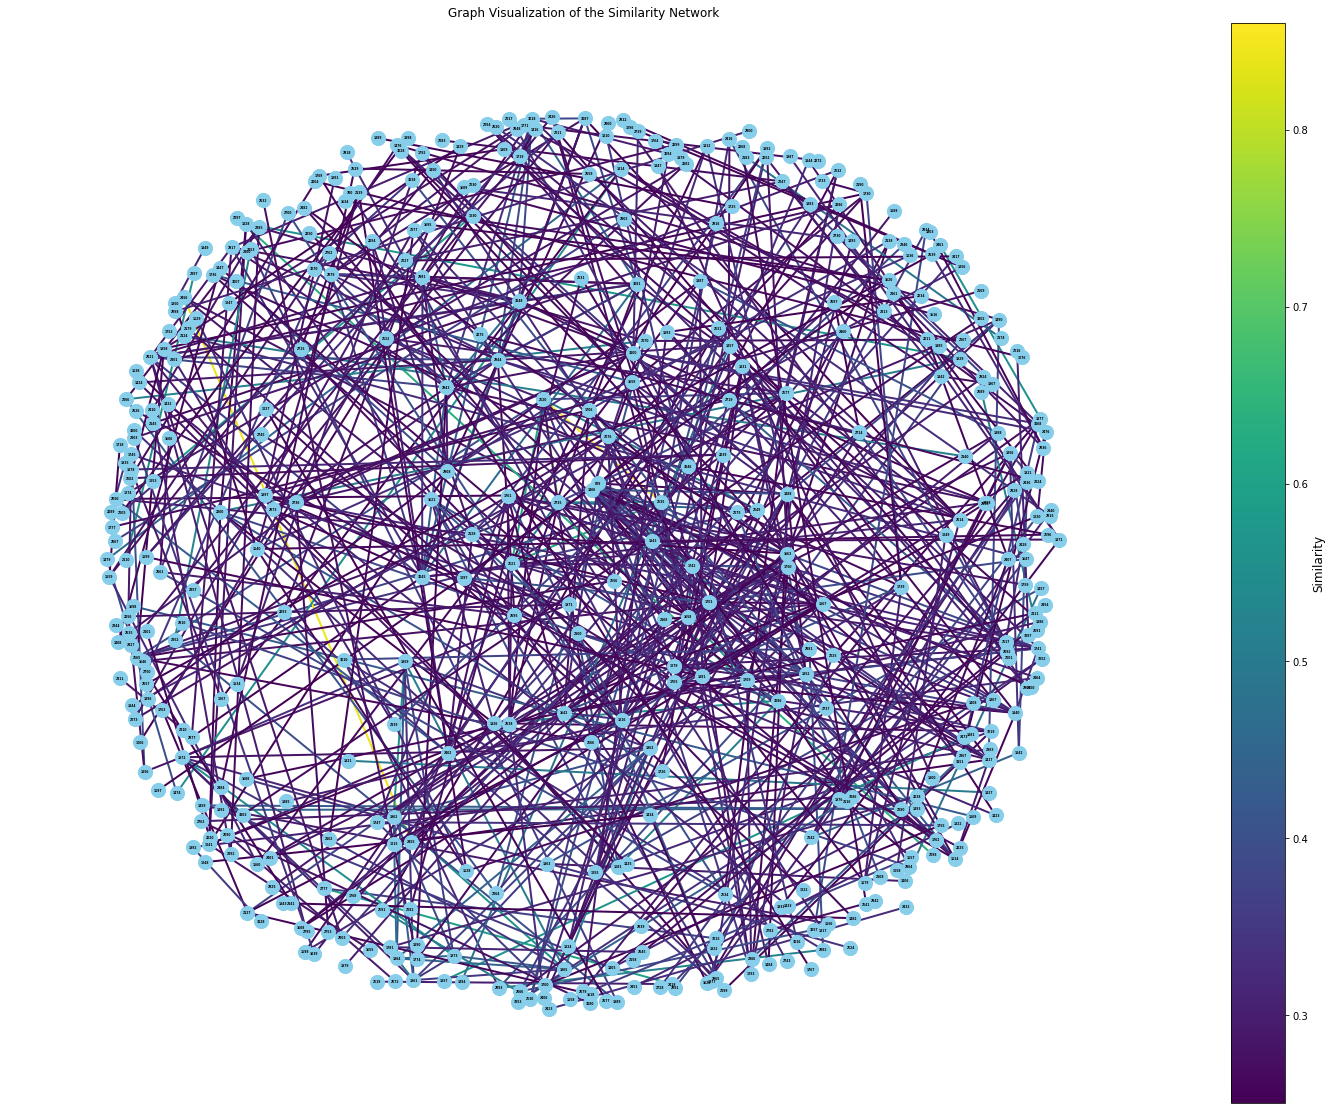

In [28]:
#1910-1919
cosine_sim_df_1910_1919=TFIDF(df_1910_1919)
mean_1910_1919, std_1910_1919 = sim_stat(cosine_sim_df_1910_1919)
find_k(cosine_sim_df_1910_1919,mean_1910_1919,std_1910_1919)
k=5
similarity_threshold_1910_1919 = mean_1910_1919 + k * std_1910_1919
print("Similarity Threshold:", similarity_threshold_1901_1909)
cosine_sim_df_1910_1919 = pd.DataFrame(cosine_sim_df_1910_1919)
mask = (cosine_sim_df_1910_1919 > similarity_threshold_1910_1919) & np.triu(np.ones(cosine_sim_df_1910_1919.shape), k=1).astype(bool)
similarity_df_1910_1919 = cosine_sim_df_1910_1919.where(mask).stack().reset_index()
similarity_df_1910_1919.columns = ['Row1', 'Row2', 'Similarity']
similarity_df_1910_1919 = similarity_df_1910_1919.sort_values(by='Similarity', ascending=False)
similarity_df_1910_1919.rename(columns={similarity_df_1910_1919.columns[0]: 'Letter_A', similarity_df_1910_1919.columns[1]: 'Letter_B'}, inplace=True)
print(similarity_df_1910_1919)
plot_network(similarity_df_1910_1919)
similarity_df_1910_1919.to_csv("similarity_df_1910_1919.csv")


__________________________________1910-1919 Network Metrics__________________________________
Size of the network:  442
Number of links in the network:  706
Network Density: 0.007243923210309765
Average Clustering Coefficient: 0.10956945579776466
Number of Connected Components: 72
Graph is not connected, cannot compute average path length.


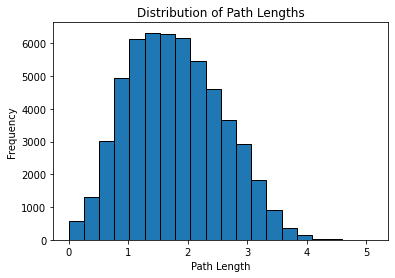

Graph is not connected, cannot compute diameter.
Average Degree: 3.1945701357466065


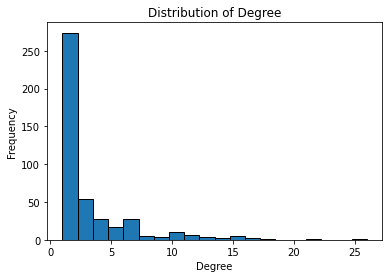

Degree Distribution Stats:
 Mean: 3.1945701357466065, Std: 3.513795362124968, Median: 2.0


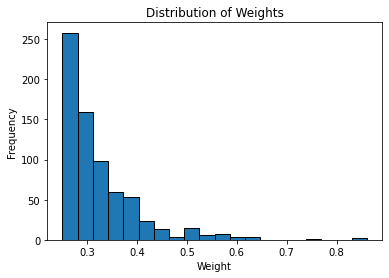

Weight Distribution Stats:
 Mean: 0.32266303725967854, Std: 0.07883360600680797, Median: 0.29765622492896565
Top 10 Degree Centrality:
[(1658, 0.05895691609977324), (1701, 0.049886621315192746), (1352, 0.04081632653061225), (829, 0.03854875283446712), (1742, 0.03854875283446712), (2621, 0.034013605442176874), (1709, 0.034013605442176874), (2943, 0.034013605442176874), (1750, 0.034013605442176874), (1488, 0.034013605442176874)]
Top 10 Betweenness Centrality:
[(1658, 0.08034425891568749), (1831, 0.04642341785198928), (1726, 0.04487734487734488), (2260, 0.04420737992166564), (2602, 0.04072356215213358), (1579, 0.039940218511647085), (1739, 0.03955885384456813), (1241, 0.037744794887652026), (2514, 0.036446093588950734), (1958, 0.03609565038136467)]
Top 10 Eigenvector Centrality:
[(1658, 0.3336841916755959), (1352, 0.31225336691774436), (829, 0.30103375860795895), (1701, 0.2651952501496238), (1750, 0.26239453725542283), (1709, 0.2527716597046184), (1742, 0.24673761203113742), (1514, 0.1846

In [29]:
print("__________________________________1910-1919 Network Metrics__________________________________")
analyze_graph(similarity_df_1910_1919)
advanced_metrics(similarity_df_1910_1919)

# Network Analysis Complete 1920-1927

Minimum similarity (excluding diagonal): 0.0000
Maximum similarity (excluding diagonal): 0.9626
Mean similarity (excluding diagonal): 0.0622
Standard Deviation of similarity (excluding diagonal): 0.0500


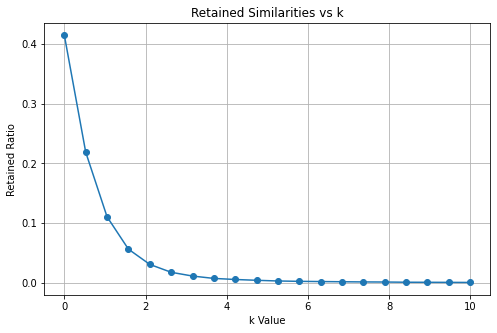

Similarity Threshold: 0.3121429491031867
     Letter_A  Letter_B  Similarity
190      1135      1151    0.962601
82        399       860    0.942019
145       859       861    0.914733
193      1151      1212    0.865643
141       857       859    0.861334
..        ...       ...         ...
60        218       662    0.313073
143       858       859    0.312868
120       664       726    0.312849
25         57       261    0.312389
1           0      1077    0.312237

[196 rows x 3 columns]


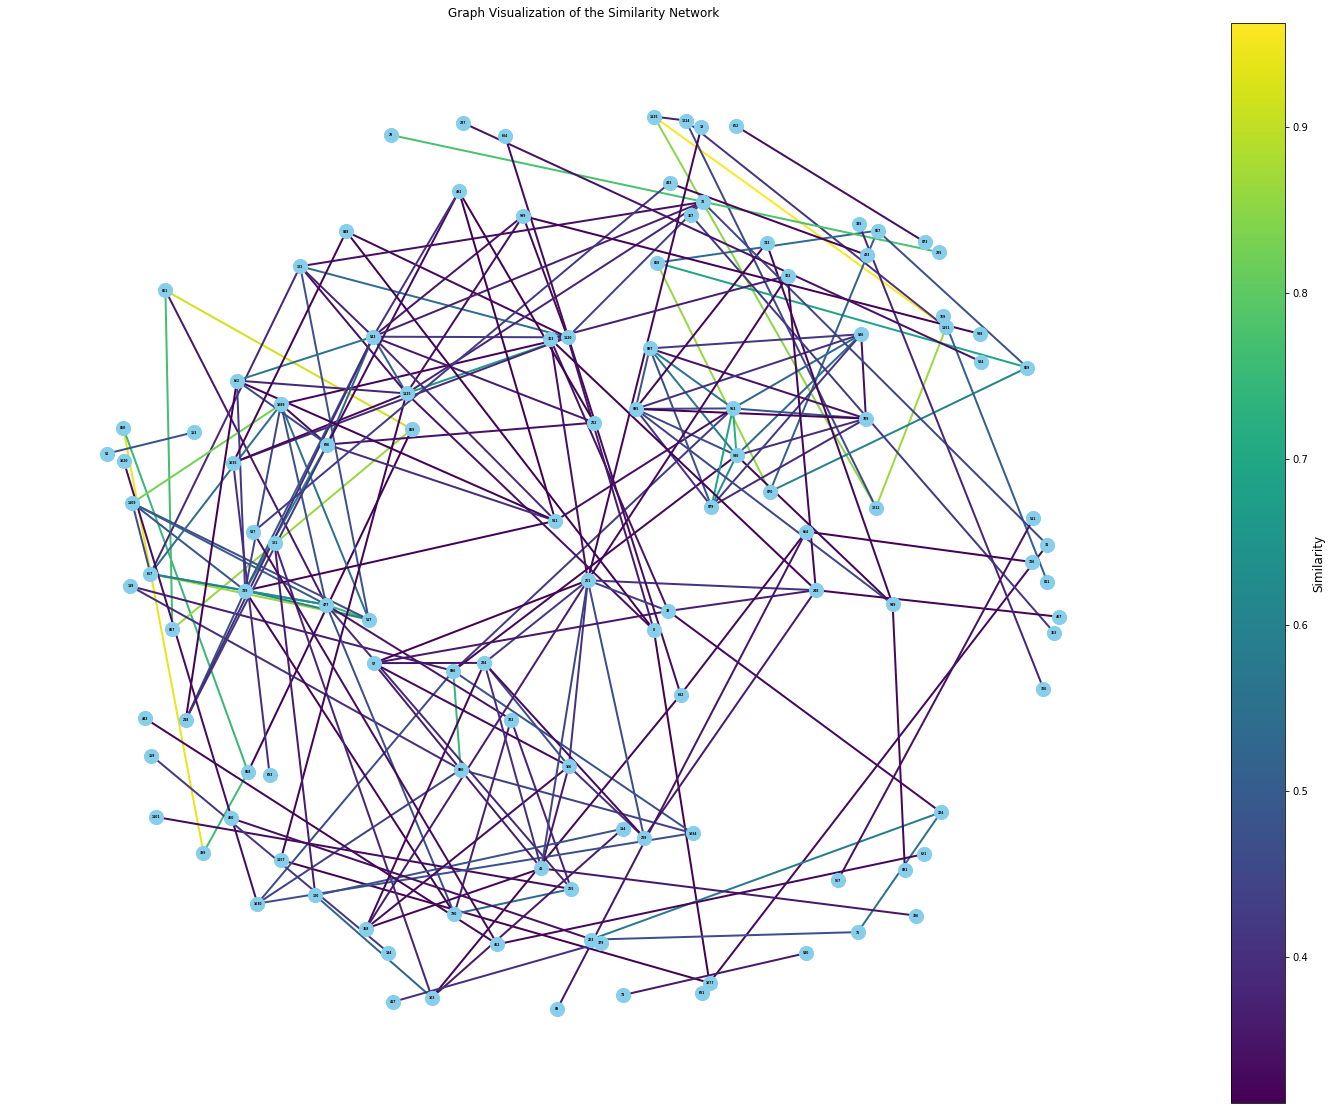

In [30]:
#1920-1927
cosine_sim_df_1920_1927=TFIDF(df_1920_1927)
mean_1920_1927, std_1920_1927 = sim_stat(cosine_sim_df_1920_1927)
find_k(cosine_sim_df_1920_1927,mean_1920_1927,std_1920_1927)
k=5
similarity_threshold_1920_1927 = mean_1920_1927 + k * std_1920_1927
print("Similarity Threshold:", similarity_threshold_1920_1927)
cosine_sim_df_1920_1927 = pd.DataFrame(cosine_sim_df_1920_1927)
mask = (cosine_sim_df_1920_1927 > similarity_threshold_1920_1927) & np.triu(np.ones(cosine_sim_df_1920_1927.shape), k=1).astype(bool)
similarity_df_1920_1927 = cosine_sim_df_1920_1927.where(mask).stack().reset_index()
similarity_df_1920_1927.columns = ['Row1', 'Row2', 'Similarity']
similarity_df_1920_1927 = similarity_df_1920_1927.sort_values(by='Similarity', ascending=False)
similarity_df_1920_1927.rename(columns={similarity_df_1920_1927.columns[0]: 'Letter_A', similarity_df_1920_1927.columns[1]: 'Letter_B'}, inplace=True)
print(similarity_df_1920_1927)
plot_network(similarity_df_1920_1927)
similarity_df_1920_1927.to_csv("similarity_df_1920_1927.csv")



__________________________________1920-1927 Network Metrics__________________________________
Size of the network:  116
Number of links in the network:  196
Network Density: 0.029385307346326838
Average Clustering Coefficient: 0.22097729457187842
Number of Connected Components: 17
Graph is not connected, cannot compute average path length.


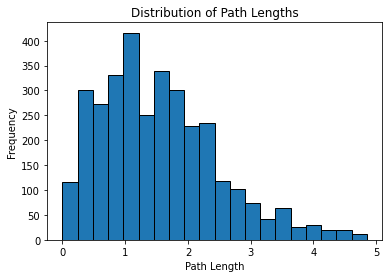

Graph is not connected, cannot compute diameter.
Average Degree: 3.3793103448275863


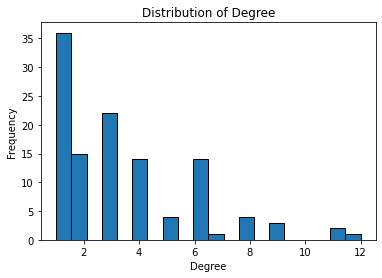

Degree Distribution Stats:
 Mean: 3.3793103448275863, Std: 2.5108563328824176, Median: 3.0


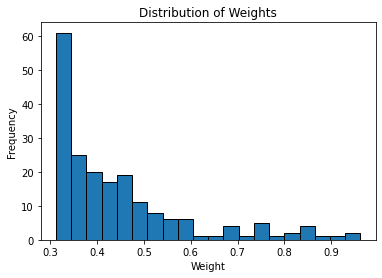

Weight Distribution Stats:
 Mean: 0.44361835868326405, Std: 0.14705848690616047, Median: 0.3959851580733185
Top 10 Degree Centrality:
[(543, 0.10434782608695653), (789, 0.09565217391304348), (261, 0.09565217391304348), (477, 0.0782608695652174), (1120, 0.0782608695652174), (1125, 0.0782608695652174), (930, 0.06956521739130435), (953, 0.06956521739130435), (696, 0.06956521739130435), (895, 0.06956521739130435)]
Top 10 Betweenness Centrality:
[(911, 0.0889397406559878), (953, 0.08466819221967964), (477, 0.049885583524027464), (789, 0.04820747520976354), (896, 0.036155606407322655), (861, 0.03585049580472922), (543, 0.030968726163234175), (1125, 0.027307398932112894), (1120, 0.02486651411136537), (1089, 0.02395118230358505)]
Top 10 Eigenvector Centrality:
[(789, 0.41385803591717607), (517, 0.36545338722526977), (477, 0.35790144805851987), (617, 0.3552454133372372), (1089, 0.33227063364664816), (1109, 0.29645562522452257), (543, 0.2261612541163427), (696, 0.2047415661605359), (122, 0.15945

In [31]:
print("__________________________________1920-1927 Network Metrics__________________________________")
analyze_graph(similarity_df_1920_1927)
advanced_metrics(similarity_df_1920_1927)